In [1]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from numpy.random import permutation


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

from diff_classifier.features import alpha_calc, unmask_track
from diff_predictor.utils import plot_msd_comparisons, plot_individual_msds, plot_particles_in_frame

import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy.ma as ma

/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

Using current directory for loading/saving: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/publication_notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [2]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
chdir('..') 
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/publication_notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/nancelab/diff_predictor


In [5]:
#load paths to data

age_feature_path = workbookDir + '/data/raw_data_age/'
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'feat' in f]
print(len(age_feature_filelist))

# age_msd_path = workbookDir + '/raw_data_age/'
# age_msd_filelist = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd' in f]
# print(len(age_msd_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

# treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
# treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f)) and 'msd' in f]
# print(len(treatment_filelist))

75
38


# Analysis of age dataset

In [21]:
fstats_tot_age = data_process.generate_fullstats(age_feature_path, age_feature_filelist, ['P14','P35', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P35_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file features_P35_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P35_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P35_brain_2_slice_1_vid_3.csv size: (1017, 91)
A

In [28]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [30]:
ecm = fstats_tot_age[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [31]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
label_df = bal_ecm[target]
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.7
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [11]:
def full_preprocess(ecm, balanced=True, y_scramble=False, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        bal_ecm = bal_ecm.reset_index(drop=True)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    if y_scramble:
        perm = permutation(len(label_df))
        label_shuffled = label_df[perm]
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(label_shuffled)
    else:
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.7
    test_split = 0.5


    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [12]:
spatial.get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 24500
Training: 17147 (0.700%)
Testing: 3677 (0.150%)
Evaluation: 3676 (0.150%)


In [13]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [25]:
predxgboost.train(param, dtrain, dtest, dval)

[0]	train-mlogloss:1.09450	eval-mlogloss:1.09468
[1]	train-mlogloss:1.09040	eval-mlogloss:1.09072
[2]	train-mlogloss:1.08667	eval-mlogloss:1.08718
[3]	train-mlogloss:1.08296	eval-mlogloss:1.08362
[4]	train-mlogloss:1.07926	eval-mlogloss:1.08001
[5]	train-mlogloss:1.07550	eval-mlogloss:1.07638
[6]	train-mlogloss:1.07160	eval-mlogloss:1.07269
[7]	train-mlogloss:1.06769	eval-mlogloss:1.06902
[8]	train-mlogloss:1.06375	eval-mlogloss:1.06522
[9]	train-mlogloss:1.05980	eval-mlogloss:1.06150
[10]	train-mlogloss:1.05603	eval-mlogloss:1.05786
[11]	train-mlogloss:1.05280	eval-mlogloss:1.05473
[12]	train-mlogloss:1.04901	eval-mlogloss:1.05109
[13]	train-mlogloss:1.04522	eval-mlogloss:1.04737
[14]	train-mlogloss:1.04148	eval-mlogloss:1.04388
[15]	train-mlogloss:1.03797	eval-mlogloss:1.04048
[16]	train-mlogloss:1.03432	eval-mlogloss:1.03706
[17]	train-mlogloss:1.03072	eval-mlogloss:1.03362
[18]	train-mlogloss:1.02735	eval-mlogloss:1.03038
[19]	train-mlogloss:1.02385	eval-mlogloss:1.02709
[20]	train

(<xgboost.core.Booster at 0x7ff5b33788b0>,
 0.8518687329079307,
 array([2., 2., 1., ..., 1., 1., 2.], dtype=float32),
 [2,
  2,
  1,
  1,
  1,
  2,
  2,
  0,
  1,
  2,
  2,
  2,
  1,
  0,
  1,
  2,
  0,
  1,
  1,
  2,
  0,
  0,
  0,
  0,
  2,
  2,
  2,
  1,
  1,
  2,
  0,
  0,
  1,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  0,
  1,
  1,
  2,
  2,
  2,
  0,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  1,
  0,
  1,
  0,
  2,
  2,
  1,
  0,
  1,
  2,
  0,
  2,
  2,
  2,
  2,
  0,
  1,
  2,
  2,
  2,
  2,
  0,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  2,
  1,
  2,
  0,
  2,
  0,
  0,
  2,
  2,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  2,
  1,
  1,
  2,
  1,
  0,
  2,
  0,
  0,
  0,
  1,
  1,
  2,
  0,
  0,
  2,
  2,
  1,
  1,
  0,
  1,
  2,
  0,
  0,
  0,
  1,
  2,
  1,
  0,
  0,
  1,
  2,
  2,
  2,
  0,
  0,
  0,
  2,
  2,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  2,
  2,
  0,
  2,
  0,
  0,
  2,
  1,
  1,
  2,
  2,
  0,
  0,
  2,
  1,
  0,
  1,
  2,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  1,
  0,
  0,
  

In [ ]:
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train=X_train, y_train=X_train['encoded_target'], features=features, init_params=param)

In [24]:
best_param = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [23]:
best_param = {'max_depth': 4, 'eta': 0.01, 'min_child_weight': 2, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 5, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss'}

In [15]:
def get_multimodel_averages(target_column, classes, data, params, num_boost_rounds, balanced=True, y_scramble=False, models_to_run=50):
    """

    """

    results_dict = {
        'tot_acc_vals': np.zeros(models_to_run),
        'tot_prec_vals': np.zeros(models_to_run),
        'tot_rec_vals': np.zeros(models_to_run),
        'tot_f1_vals': np.zeros(models_to_run),
        'booster_list': list(range(models_to_run)),
        'truelabels_list': list(range(models_to_run)),
        'preds_list': list(range(models_to_run)),
        'xtest_list': list(range(models_to_run))
    }


    for class_name in classes:
        key_name_acc = class_name + '_acc_vals'
        results_dict[key_name_acc] = np.zeros(models_to_run)

        key_name_prec = class_name + '_prec_vals'
        results_dict[key_name_prec] = np.zeros(models_to_run)

        key_name_rec = class_name + '_rec_vals'
        results_dict[key_name_rec] = np.zeros(models_to_run)

        key_name_f1 = class_name + '_f1_vals'
        results_dict[key_name_f1] = np.zeros(models_to_run)
    


    for i in range(models_to_run):
        print(i)

        dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=balanced, target=target_column, y_scramble=y_scramble)
        booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=num_boost_rounds, verbose=False)

        preds = np.array(preds)

        results_dict['tot_acc_vals'][i] = accuracy_score(true_label, preds)
        results_dict['tot_prec_vals'][i] = precision_score(true_label, preds, average='macro')
        results_dict['tot_rec_vals'][i] = recall_score(true_label, preds, average='macro')
        results_dict['tot_f1_vals'][i] = f1_score(true_label, preds, average='macro')

        results_dict['xtest_list'][i] = X_test

        results_dict['booster_list'][i] = booster
        results_dict['truelabels_list'][i] = true_label
        results_dict['preds_list'][i] = preds

        prec, rec, f1, sup = precision_recall_fscore_support(true_label, preds)

        for class_name in classes:
            class_label = np.where(le.classes_ == class_name)
            class_idx = np.where(true_label == class_label[0])

            key_name_acc = class_name + '_acc_vals'
            results_dict[key_name_acc][i] = accuracy_score(true_label[class_idx], preds[class_idx])

            key_name_prec = class_name + '_prec_vals'
            results_dict[key_name_prec][i] = prec[class_label]

            key_name_rec = class_name + '_rec_vals'
            results_dict[key_name_rec][i] = rec[class_label]

            key_name_f1 = class_name + '_f1_vals'
            results_dict[key_name_f1][i] = f1[class_label]

    return results_dict

In [17]:
age_results_dict_100models = get_multimodel_averages('age', ecm['age'].unique(), ecm, best_param, 767, models_to_run=10, y_scramble=False)

0
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P35:P28:P21) = 4900:4900:4900:4900:4900
Accuracy: 0.5799465240641711
1
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P35:P28:P21) = 4900:4900:4900:4900:4900
Accuracy: 0.5750276854928018
2
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P35:P28:P21) = 4900:4900:4900:4900:4900
Accuracy: 0.5621175844639532
3
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P35:P28:P21) = 4900:4900:4900:4900:4900
Accuracy: 0.584587905077826
4
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P35:P28:P21) = 4900:4900:4900:4900:4900
Accuracy: 0.5618996798292423
5
Ratio before data balance (P70:P14:P35:P28:P21) = 13968:4900:14869:5098:17175
Ratio after balance (P70:P14:P3

In [20]:
from scipy import stats


In [18]:
for key in age_results_dict_100models.keys():
    value = age_results_dict_100models[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        # fig = plt.figure()
        # plt.hist(value, bins=25)
        # plt.title(f'age, {key}')
        print(f'age, {key}')
        print(np.median(value))
        print(stats.iqr(value, interpolation='midpoint'))
        print()

age, tot_acc_vals
0.5749901235813155
0.015166469561616824

age, tot_prec_vals
0.5548544605331827
0.009609904387309243

age, tot_rec_vals
0.5760821583450955
0.00981066478942394

age, tot_f1_vals
0.5608495094516099
0.010702123328861557

age, P70_acc_vals
0.8984388543433202
0.029011037935861905

age, P70_prec_vals
0.7703285928582801
0.024317800459217498

age, P70_rec_vals
0.8984388543433202
0.029011037935861905

age, P70_f1_vals
0.8276933162910156
0.02155951264382805

age, P14_acc_vals
0.7322541418278901
0.046034417026089125

age, P14_prec_vals
0.6787869669157598
0.02010048986605628

age, P14_rec_vals
0.7322541418278901
0.046034417026089125

age, P14_f1_vals
0.7084153110556369
0.021908690140981513

age, P35_acc_vals
0.5013307115419792
0.020573067960606206

age, P35_prec_vals
0.48496751308132857
0.02546193667157559

age, P35_rec_vals
0.5013307115419792
0.020573067960606206

age, P35_f1_vals
0.4960342029778363
0.029754537620994115

age, P28_acc_vals
0.2844701874363584
0.020861744293188766



In [ ]:
for key in age_results_dict.keys():
    value = age_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        fig = plt.figure()
        plt.hist(value, bins=25)
        plt.title(f'age, {key}')

In [ ]:
age_yscramb_results_dict = get_multimodel_averages('age', ecm['age'].unique(), ecm, best_param, 804, models_to_run=50, y_scramble=True)

In [ ]:
for key in age_yscramb_results_dict.keys():
    value = age_yscramb_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic)):
        fig = plt.figure()
        plt.hist(value, bins=25)

In [ ]:
# def get_multimodel_averages(target, models_to_run=50, )

#     age_tot_acc_vals = np.zeros(models_to_run)
#     age_tot_prec_vals = np.zeros(models_to_run)
#     age_tot_rec_vals = np.zeros(models_to_run)
#     age_tot_f1_vals = np.zeros(models_to_run)

#     age_booster_list = list(range(models_to_run))
#     age_truelabels_list = list(range(models_to_run))
#     age_preds_list = list(range(models_to_run))
#     age_xtest_list = list(range(models_to_run))

#     P14_acc_vals = np.zeros(models_to_run)
#     P35_acc_vals = np.zeros(models_to_run)
#     P70_acc_vals = np.zeros(models_to_run)

#     P14_prec_vals = np.zeros(models_to_run)
#     P35_prec_vals = np.zeros(models_to_run)
#     P70_prec_vals = np.zeros(models_to_run)

#     P14_rec_vals = np.zeros(models_to_run)
#     P35_rec_vals = np.zeros(models_to_run)
#     P70_rec_vals = np.zeros(models_to_run)

#     P14_f1_vals = np.zeros(models_to_run)
#     P35_f1_vals = np.zeros(models_to_run)
#     P70_f1_vals = np.zeros(models_to_run)

#     P14_sup_vals = np.zeros(models_to_run)
#     P35_sup_vals = np.zeros(models_to_run)
#     P70_sup_vals = np.zeros(models_to_run)

#     for i in range(models_to_run):
#         print(i)


#         dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, balanced=True, target=target)
#         booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=804, verbose=False)

#         preds = np.array(preds)

#         age_tot_acc_vals[i] = accuracy_score(true_label, preds)
#         age_tot_prec_vals[i] = precision_score(true_label, preds, average='macro')
#         age_tot_rec_vals[i] = recall_score(true_label, preds, average='macro')
#         age_tot_f1_vals[i] = f1_score(true_label, preds, average='macro')

#         age_xtest_list[i] = X_test

#         age_booster_list[i] = booster
#         age_truelabels_list[i] = true_label
#         age_preds_list[i] = preds

#         prec, rec, f1, sup = precision_recall_fscore_support(true_label, preds)

#         p14_idx = np.where(le.classes_=='P14')
#         p35_idx = np.where(le.classes_=='P35')
#         p70_idx = np.where(le.classes_=='P70')

#         p14_locs = np.where(true_label==p14_idx[0])
#         p35_locs = np.where(true_label==p35_idx[0])
#         p70_locs = np.where(true_label==p70_idx[0])

#         P14_acc_vals[i] = accuracy_score(true_label[p14_locs], preds[p14_locs])
#         P35_acc_vals[i] = accuracy_score(true_label[p35_locs], preds[p35_locs])
#         P70_acc_vals[i] = accuracy_score(true_label[p70_locs], preds[p70_locs])


#         P14_prec_vals[i] = prec[p14_idx]
#         P35_prec_vals[i] = prec[p35_idx]
#         P70_prec_vals[i] = prec[p70_idx]

#         P14_rec_vals[i] = rec[p14_idx]
#         P35_rec_vals[i] = rec[p35_idx]
#         P70_rec_vals[i] = rec[p70_idx]

#         P14_f1_vals[i] = f1[p14_idx]
#         P35_f1_vals[i] = f1[p35_idx]
#         P70_f1_vals[i] = f1[p70_idx]

#         P14_sup_vals[i] = sup[p14_idx]
#         P35_sup_vals[i] = sup[p35_idx]
#         P70_sup_vals[i] = sup[p70_idx]

In [ ]:
true_label[p14_locs]

In [35]:
print(P70_acc_vals.mean())
print(P70_acc_vals.std())

0.8902607314657308
0.02589096489349323


In [187]:
print(age_tot_acc_vals.mean())
print(age_tot_acc_vals.std())

0.8584827855749743
0.014677869312409185


In [189]:
print(age_tot_prec_vals.mean())
print(age_tot_prec_vals.std())

0.8595011780750523
0.013855097930660216


In [190]:
print(age_tot_rec_vals.mean())
print(age_tot_rec_vals.std())

0.8584085215764672
0.014709813769048521


In [193]:
print(age_tot_f1_vals.mean())
print(age_tot_f1_vals.std())

0.8583694899759665
0.014457156144658657


In [205]:
print(P14_sup_vals.mean())
print(P14_sup_vals.std())

501.64
31.307353768723413


In [203]:
print(P35_f1_vals.mean())
print(P35_f1_vals.std())

0.7938346709096384
0.023021581017159978


In [204]:
print(P70_f1_vals.mean())
print(P70_f1_vals.std())

0.8885406012891667
0.015941584590266095


In [58]:
len(P14_acc_vals)

50

In [67]:
medIdx = list(age_tot_acc_vals).index(np.percentile(age_tot_acc_vals,50,interpolation='nearest'))
medIdx

6

In [21]:
med = np.argsort(age_yscramb_results_dict['tot_acc_vals'])[len(age_yscramb_results_dict['tot_acc_vals'])//2]
med

26

In [69]:
min_idx = np.argsort(age_tot_acc_vals)[0]
max_idx = np.argsort(age_tot_acc_vals)[-1]
print(min_idx)
print(max_idx)

0
24


In [18]:
age_yscramb_results_dict['booster_list']

In [23]:
booster = age_yscramb_results_dict['booster_list'][med]
class_names = le.classes_




In [27]:
age_yscramb_results_dict['xtest_list'][med]

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean Deff1,Mean Deff2,age,Track_ID,X,Y,binx,biny,bins,encoded_target
523,0.054150,15.427575,2.819854,0.823019,0.220580,0.228009,1.940569,0.484687,0.103370,1.491983,...,5.285975,NaN,P70,618.0,1682.827364,1631.303354,13,12,220,2
9703,1.433959,41.578090,1.725618,0.982039,0.067314,0.480973,2.975270,0.663896,0.087494,1.245701,...,61.072378,NaN,P14,30.0,992.162478,1727.882306,7,13,125,1
1453,0.001201,15.984150,3.084673,0.705446,0.294976,0.160406,1.596484,0.373623,0.123120,2.226631,...,4.253278,NaN,P70,1411.0,521.476329,1163.001314,4,9,73,0
12718,0.031740,23.735935,3.112723,0.675616,0.312602,0.147487,2.066275,0.516037,0.038101,1.873860,...,2.653923,NaN,P35,1394.0,1895.124134,837.753580,14,6,230,2
5567,0.307333,16.413754,2.504877,0.399277,0.474950,0.065457,1.622828,0.383792,0.105928,1.855907,...,18.269532,NaN,P14,204.0,1033.262834,1989.456426,8,15,143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,0.036465,61.717547,2.786567,0.687271,0.305750,0.152389,1.064107,0.060245,0.133286,1.965631,...,30.997981,NaN,P14,644.0,309.017254,457.382325,2,3,35,0
818,1.091813,0.797241,3.613479,0.992702,0.042793,0.546962,4.781489,0.790860,0.036586,1.792446,...,5.150792,NaN,P70,2210.0,1156.749844,43.229829,9,0,144,2
7286,0.140523,118.475875,2.051875,0.882839,0.176474,0.281033,1.670010,0.401201,0.064791,1.665293,...,21.080736,NaN,P14,234.0,1413.908308,2010.097706,11,15,191,2
13078,0.303370,65.432893,1.966287,0.922702,0.141808,0.331923,2.931466,0.658874,0.029352,1.548004,...,3.994299,0.207952,P35,130.0,291.816162,1820.571736,2,14,46,2


In [71]:
age_xtest_list

[              alpha      D_fit  kurtosis  asymmetry1  asymmetry2  asymmetry3  \
 20993  1.492846e+00   6.916979  5.281985    0.804796    0.232891    0.215136   
 23988  1.230321e+00   7.541207  4.452591    0.471091    0.431261    0.082242   
 26911  5.083511e-01   4.563315  3.347103    0.619188    0.345349    0.126007   
 1097   3.239361e-01   2.386926  2.170767    0.508829    0.409051    0.092056   
 23126  1.133101e+00   0.132656  4.484072    0.408527    0.469187    0.067495   
 ...             ...        ...       ...         ...         ...         ...   
 27774  3.644767e-01  24.136584  1.910919    0.954556    0.107827    0.391981   
 30818  1.556737e-01  41.499540  1.811395    0.728354    0.281205    0.171236   
 5376   5.324690e-01  48.817629  1.413511    0.955191    0.107054    0.393486   
 20837  7.121904e-01  39.265934  2.443010    0.601573    0.355489    0.119957   
 28402  8.202141e-07  26.814678  2.790250    0.841661    0.207528    0.242517   
 
              AR  elongati

In [29]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(age_yscramb_results_dict['xtest_list'][med])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[feature_list], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields age, binx, biny

In [78]:
class_names

array(['P14', 'P35', 'P70'], dtype=object)

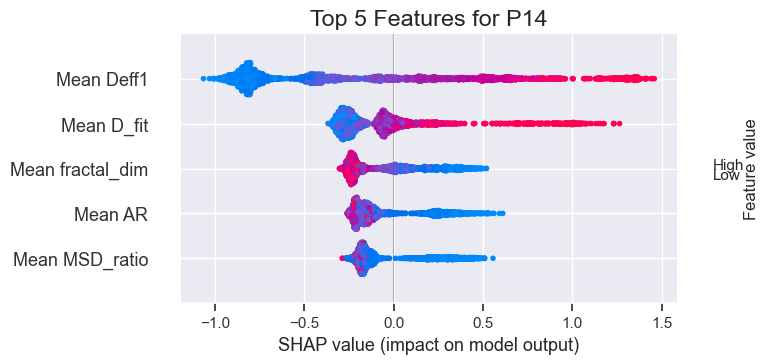

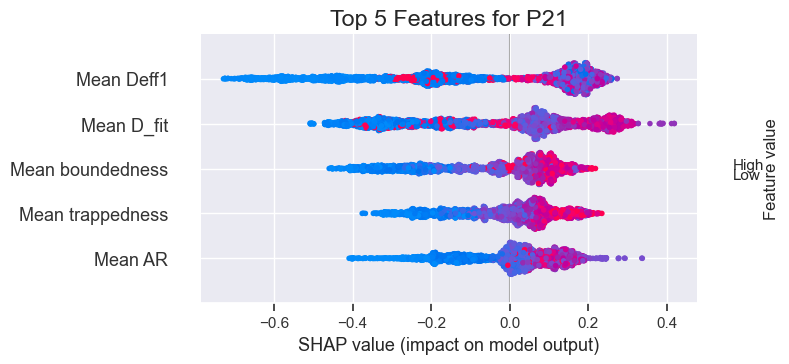

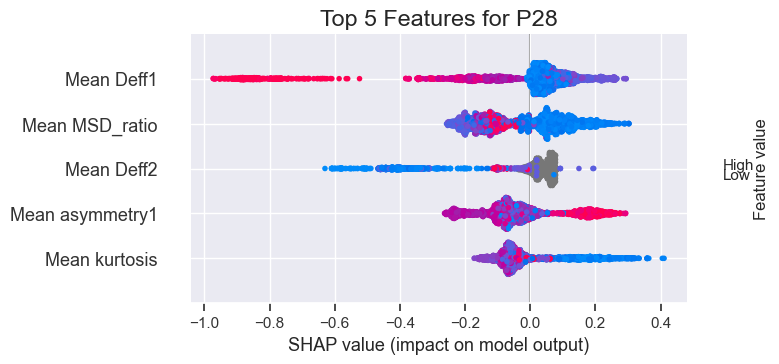

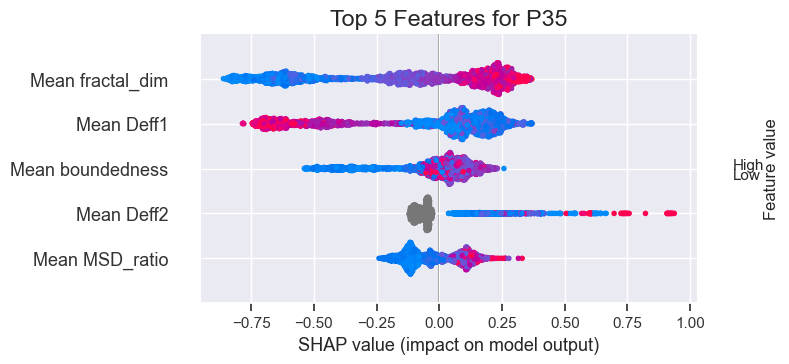

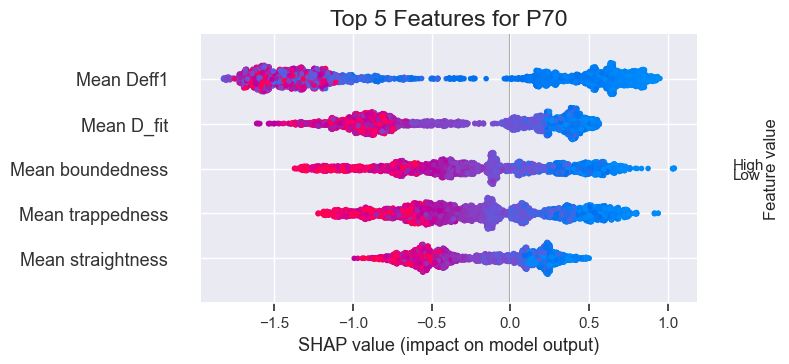

In [20]:
for i in range(5): 
    figsize = (7.5, 5)
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    shap.summary_plot(shap_values[i], X_test[feature_list], max_display=5, show=False)
    ax.set_title(f'Top 5 Features for {le.classes_[i]}')

In [32]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=804, verbose=False)


Accuracy: 0.8682771194165907


In [35]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.9105    0.8869    0.8986       734
         P35     0.7953    0.8354    0.8149       735
         P70     0.9052    0.8828    0.8939       725

    accuracy                         0.8683      2194
   macro avg     0.8704    0.8684    0.8691      2194
weighted avg     0.8702    0.8683    0.8690      2194



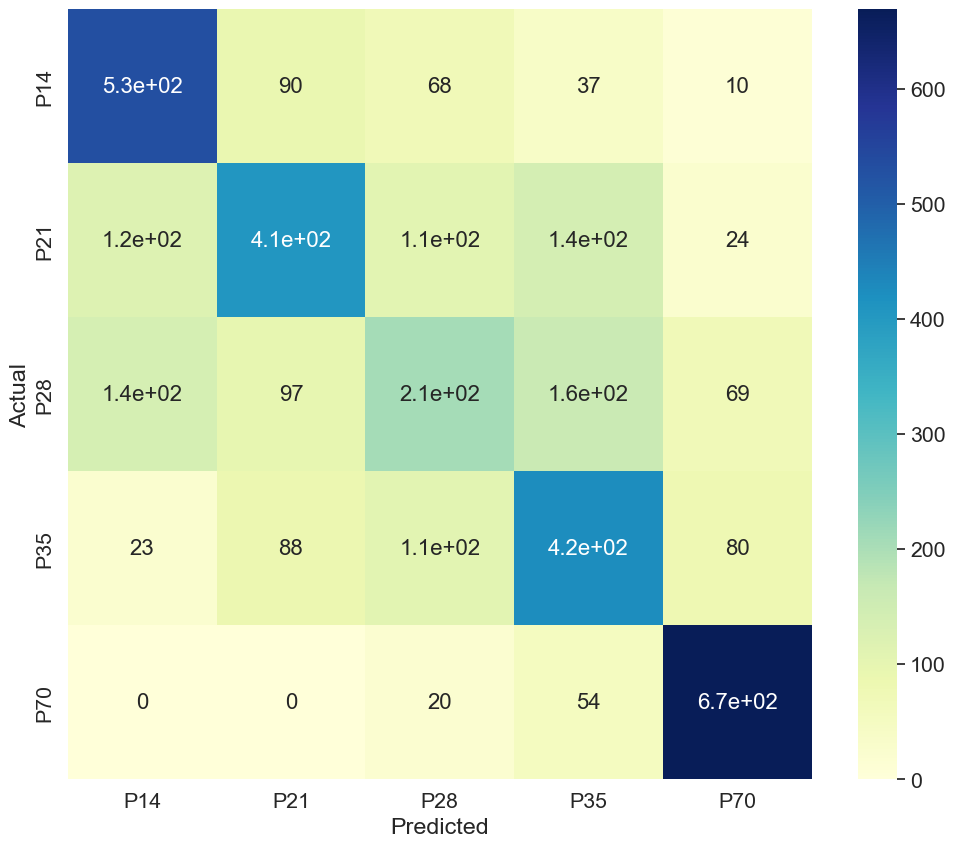

In [14]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [15]:
# Needed bc of this issue: https://github.com/slundberg/shap/issues/1215

# model_bytearray = booster.save_raw()[4:]
# def myfun(self=None):
#     return model_bytearray

# booster.save_raw = myfun

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

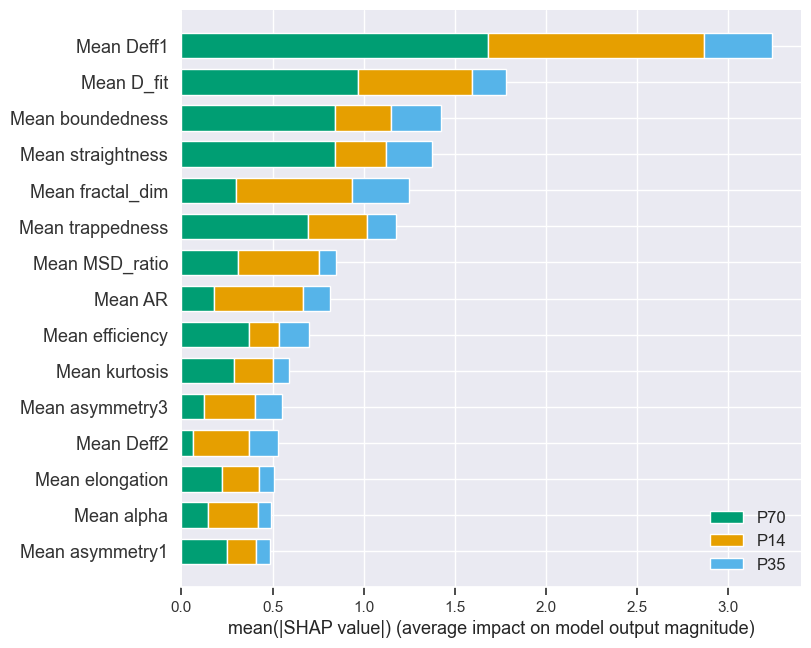

In [36]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

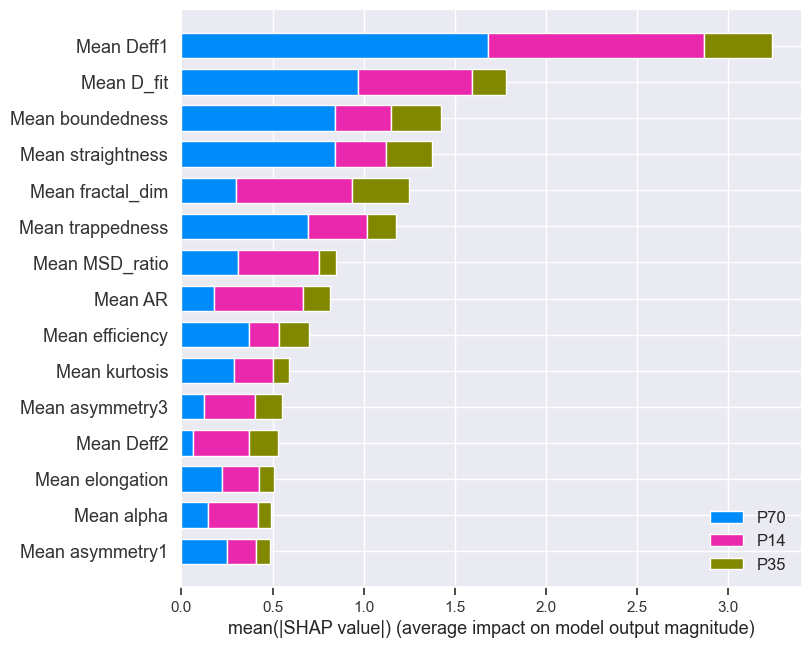

In [37]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')

### Outlier detection

In [141]:
scaler = StandardScaler()
features_df_filled = ecm[features].fillna(0)
scaled_df = scaler.fit_transform(features_df_filled)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [56]:
features_df_filled['alpha']

NameError: name 'features_df_filled' is not defined

In [143]:
L, S = r_pca.R_pca(scaled_df).fit(max_iter=5000)

iteration: 1, error: 0.33742470791242857
iteration: 100, error: 0.001421840460143009
iteration: 200, error: 0.0013442431841444197
iteration: 300, error: 0.001215150157510675
iteration: 400, error: 0.0012335808700662872
iteration: 500, error: 0.0013130438417539698
iteration: 600, error: 0.0010457216617579263
iteration: 700, error: 0.0009347528430520776
iteration: 800, error: 0.0008423601595553127
iteration: 900, error: 0.001320473470684468
iteration: 1000, error: 0.0011761343495920312
iteration: 1100, error: 0.0010545241944393147
iteration: 1200, error: 0.0010628053284969497
iteration: 1300, error: 0.0010749386138158617
iteration: 1400, error: 0.0011235594104969397
iteration: 1500, error: 0.0012754471686809705
iteration: 1600, error: 0.001805255420123608
iteration: 1700, error: 0.0014422658761289813
iteration: 1800, error: 0.005292204487216265
iteration: 1900, error: 0.002065234913357426
iteration: 2000, error: 0.002184229327285333
iteration: 2100, error: 0.006379436826808724
iteration:

In [144]:
S_array = np.absolute(S.values)
S_array

S_magnitudes = np.zeros(len(S))
for i in range(len(S)):
    abs_sum = np.sum(S_array[i])
    S_magnitudes[i] = abs_sum

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  1.15212212,   1.17426878,   1.19641545, ..., 111.84114911,
        111.86329577, 111.88544243]),
 <BarContainer object of 5000 artists>)

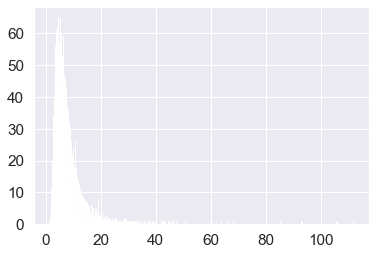

In [65]:
plt.hist(S_magnitudes, bins=5000)

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

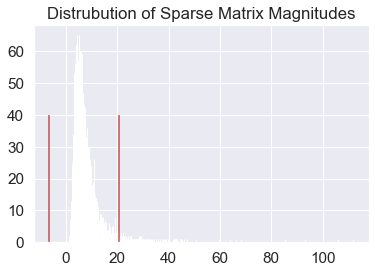

In [66]:
plt.hist((S_magnitudes), bins=5000)
plt.vlines((S_magnitudes).mean()+((S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.vlines((S_magnitudes).mean()-((S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

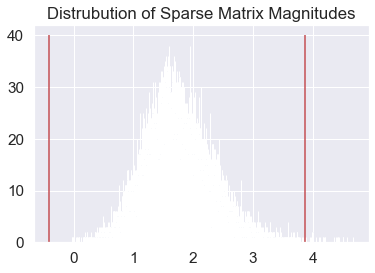

In [184]:
plt.hist(np.log(S_magnitudes), bins=5000)
plt.vlines(np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*4), ymin=0, ymax=40, color='r')
plt.vlines(np.log(S_magnitudes).mean()-(np.log(S_magnitudes).std()*4), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

In [63]:
outlier_df


,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2,treatment,Track_ID,X,Y
1239,0.270957,3.443641,2.141585,0.375851,0.489769,0.060440,1.293403,0.226846,0.148174,2.129604,...,-0.197048,0.301700,0.135323,0.204952,1.750885,NaN,ChABC,1239.0,1710.921582,417.490590
1629,0.900042,7.380534,1.514717,0.877297,0.180875,0.275202,3.049137,0.672038,0.083455,1.698174,...,-0.199124,0.904964,0.278762,0.015079,12.787202,NaN,ChABC,389.0,252.337572,730.500979
3365,0.999121,3.134894,3.293780,0.952451,0.110356,0.387105,2.582958,0.612847,0.111732,1.722076,...,-0.202009,0.399380,0.133869,0.321940,2.298746,0.872661,NT,1411.0,1763.877225,630.341509
3639,1.697688,0.021310,2.665182,0.518943,0.403157,0.094821,1.286507,0.222701,0.107142,2.159621,...,-0.181769,1.023122,0.287243,3.695344,1.142224,NaN,NT,1685.0,1087.631988,149.090143
3972,0.451358,15.973895,2.974686,0.819196,0.223196,0.225209,1.861685,0.462852,0.073890,1.431299,...,-0.196816,1.006079,0.235655,0.309146,6.836896,NaN,ChABC,142.0,672.455610,1549.811421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109653,0.204918,55.142976,2.593115,0.515017,0.405443,0.093741,1.228565,0.186042,0.051740,1.933005,...,-0.200812,0.604285,0.188729,0.881983,6.315599,NaN,ChABC,1267.0,2014.032413,174.558857
111698,0.461360,21.481096,1.760072,0.054099,0.789048,0.006976,1.065995,0.061909,0.204759,1.983075,...,-0.185888,0.673068,0.237749,0.301623,6.253111,NaN,ChABC,1495.0,1882.543353,77.243867
115277,1.339572,7.008847,2.049599,0.931995,0.132685,0.346952,2.396813,0.582779,0.013180,1.440082,...,-0.203505,1.001267,0.246135,0.281003,13.689165,0.820738,ChABC,2050.0,1996.915924,267.546836
115354,0.400503,65.522939,2.052181,0.138918,0.675991,0.018864,1.123279,0.109749,0.196585,1.775133,...,-0.203505,1.001267,0.246135,0.281003,13.689165,0.820738,ChABC,2127.0,1974.570386,309.352467


In [171]:
upper_outlier_cutoff = np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*5)
S_mag_log = np.log(S_magnitudes)
outliers = S_mag_log[S_mag_log > upper_outlier_cutoff]
print(len(outliers))
outlier_inds = np.where(S_mag_log > upper_outlier_cutoff)
normal_inds = np.where(S_mag_log <= upper_outlier_cutoff)
outlier_df = ecm.iloc[outlier_inds[0]]
normal_df = ecm.iloc[normal_inds[0]]

9


In [172]:
bal_ecm = data_process.balance_data(normal_df, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (P70:P14:P35) = 13964:4900:14864
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [173]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [174]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=96, verbose=False)


Accuracy: 0.8620782003213712


In [175]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.9035    0.8753    0.8892      1187
         P35     0.8133    0.7836    0.7982      1229
         P70     0.8693    0.9234    0.8955      1318

    accuracy                         0.8621      3734
   macro avg     0.8620    0.8607    0.8610      3734
weighted avg     0.8617    0.8621    0.8615      3734



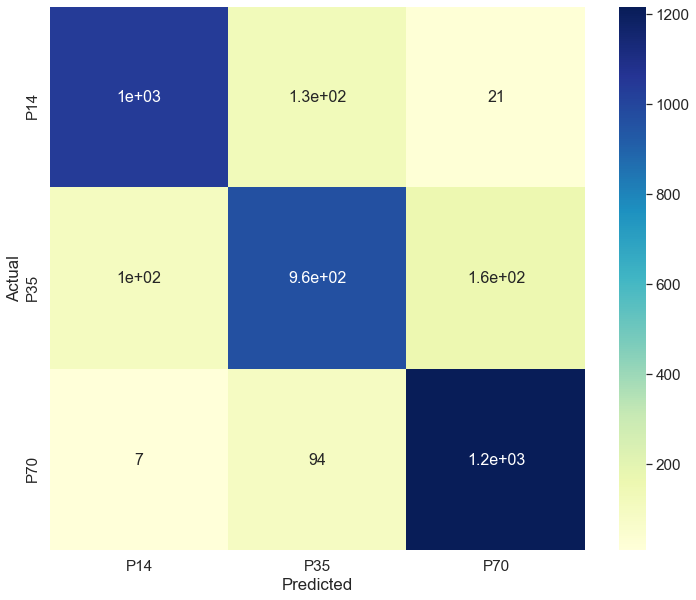

In [176]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

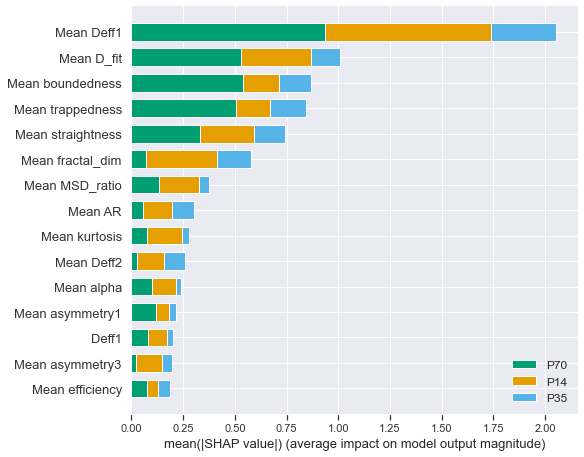

In [208]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [177]:
le_out = preprocessing.LabelEncoder()
outlier_df['encoded_target'] = le_out.fit_transform(outlier_df['age'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [178]:

y_outlier = outlier_df['encoded_target']
d_outliers = xgb.DMatrix(outlier_df[features], label=y_outlier)

In [179]:
true_label = d_outliers.get_label()
ypred = booster.predict(d_outliers)
preds = [np.where(x == np.max(x))[0][0] for x in ypred]
acc = accuracy_score(true_label, preds)
print("Accuracy:",acc)

Accuracy: 0.0


In [215]:
preds
true_label

array([1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [180]:
class_names = le.classes_
class_results = classification_report(y_outlier, preds, digits=4, target_names=le.classes_)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.0000    0.0000    0.0000       5.0
         P35     0.0000    0.0000    0.0000       4.0
         P70     0.0000    0.0000    0.0000       0.0

    accuracy                         0.0000       9.0
   macro avg     0.0000    0.0000    0.0000       9.0
weighted avg     0.0000    0.0000    0.0000       9.0



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


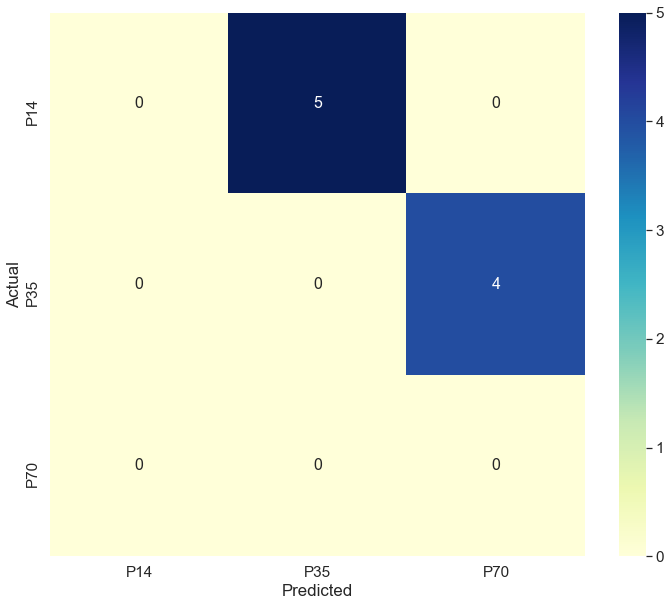

In [181]:
metrics.confusion_matrix(y_outlier, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_outlier, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

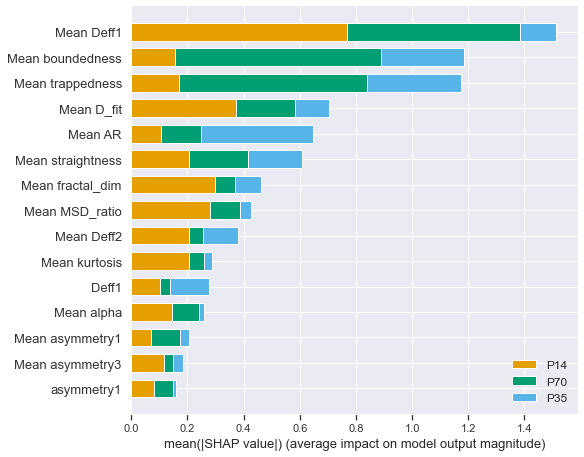

In [182]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(outlier_df[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'


colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, outlier_df[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

In [219]:
perr_alph = []
perr_dcoef = []

for i in range(len(age_msd_filelist)):

    
    msd_df = pd.read_csv(age_msd_path + age_msd_filelist[i])
    trackids = msd_df['Track_ID'].unique()
    partcount = trackids.shape[0]
    for particle in range(0, partcount):

        single_track_masked = msd_df.loc[msd_df['Track_ID'] == trackids[particle]].sort_values(['Track_ID', 'Frame'], ascending=[1,1]).reset_index(drop=True)
        single_track = unmask_track(single_track_masked)
        xpos = single_track['MSDs']
        ypos = single_track['Frame']

        def msd_alpha(xpos, alph, dcoef):
                return 4*dcoef*(xpos**alph)

        try:
            popt, pcov = curve_fit(msd_alpha, xpos, ypos)
            alph = popt[0]
            dcoef = popt[1]
            perr = np.sqrt(np.diag(pcov))
            perr_alph.append(perr[0])
            perr_dcoef.append(perr[1])
        except RuntimeError:
            print('Optimal parameters not found. Print NaN instead.')
            alph = np.nan
            dcoef = np.nan
        

Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
invalid value encountered in sqrt
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters c

In [231]:
perr_alph_arr.min()

nan

invalid value encountered in greater_equal
invalid value encountered in less_equal


(array([6.5957e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.34315942e-04, 9.62092885e+05, 1.92418577e+06, 2.88627865e+06,
        3.84837154e+06, 4.81046442e+06, 5.77255731e+06, 6.73465019e+06,
        7.69674307e+06, 8.65883596e+06, 9.62092884e+06]),
 <BarContainer object of 10 artists>)

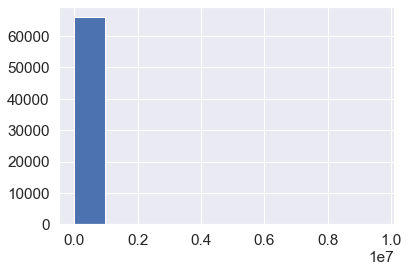

In [230]:
perr_alph_arr = np.array(perr_alph)
perr_alph_arr = perr_alph_arr[perr_alph_arr != np.inf]
perr_alph_arr = perr_alph_arr[perr_alph_arr != np.nan]

plt.hist(perr_alph_arr)

(array([6.5957e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([7.55166985e-09, 3.38748841e+06, 6.77497683e+06, 1.01624652e+07,
        1.35499537e+07, 1.69374421e+07, 2.03249305e+07, 2.37124189e+07,
        2.70999073e+07, 3.04873957e+07, 3.38748841e+07]),
 <BarContainer object of 10 artists>)

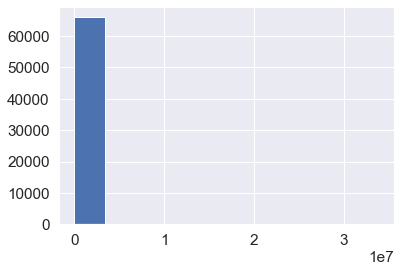

In [221]:
perr_dcoef_arr = np.array(perr_dcoef)
perr_dcoef_arr = perr_dcoef_arr[perr_dcoef_arr != np.inf]
plt.hist(perr_dcoef_arr)

# Region data

In [6]:
fstats_tot_region = data_process.generate_fullstats(region_dataset_path, region_filelist, ['cortex', 'striatum', 'hippocampus',], 'region')

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [15]:
target = 'region'
ecm = fstats_tot_region[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(125416, 36)


(96085, 36)

In [16]:
region_results_dict = get_multimodel_averages('region', ecm['region'].unique(), ecm, best_param, 1157)

NameError: name 'get_multimodel_averages' is not defined

In [25]:
for key in region_results_dict.keys():
    value = region_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        fig = plt.figure()
        plt.hist(value)
        plt.title(f'region, {key}')

SyntaxError: unexpected EOF while parsing (<ipython-input-25-ea6d0c18b124>, line 6)

In [26]:
for key in region_results_dict.keys():
    value = region_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        print(f'region, {key}')
        print(np.median(value))
        print(stats.iqr(value, interpolation= 'midpoint'))
        print()

region, tot_acc_vals
0.9010349288486417
0.027746554551609348

region, tot_prec_vals
0.8973301690528466
0.0286501551954077

region, tot_rec_vals
0.8974292599588355
0.027531721972208878

region, tot_f1_vals
0.8973721732342422
0.027587835352648415

region, striatum_acc_vals
0.8619091751621872
0.021854116262232548

region, striatum_prec_vals
0.8592132505175983
0.03980134865502383

region, striatum_rec_vals
0.8619091751621872
0.021854116262232548

region, striatum_f1_vals
0.8627858627858628
0.021358686156892293

region, cortex_acc_vals
0.8800773694390716
0.08288872088418475

region, cortex_prec_vals
0.845724907063197
0.03527699983382848

region, cortex_rec_vals
0.8800773694390716
0.08288872088418475

region, cortex_f1_vals
0.8625592417061612
0.057719693734151756

region, hippocampus_acc_vals
0.9636194029850746
0.009433763523918004

region, hippocampus_prec_vals
0.9775171065493646
0.0059365373074106165

region, hippocampus_rec_vals
0.9636194029850746
0.009433763523918004

region, hippocampus

In [18]:
region_yscramb_results_dict = get_multimodel_averages('region', ecm['region'].unique(), ecm, best_param, 200, True, True)

0
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.32243589743589746
1
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.3247269116186693
2
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.3335706657173371
3
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.33764553686934023
4
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:cortex:hippocampus) = 10063:10063:10063
Accuracy: 0.3336560180703453
5
Ratio before data balance (striatum:cortex:hippocampus) = 44214:27932:10063
Ratio after balance (striatum:corte

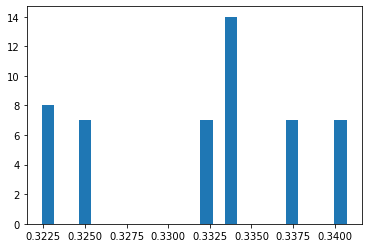

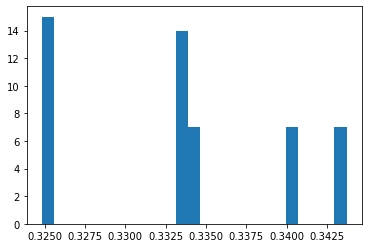

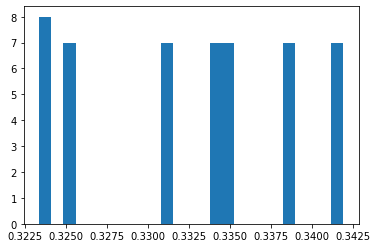

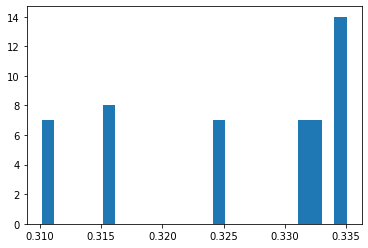

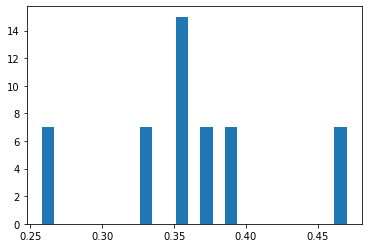

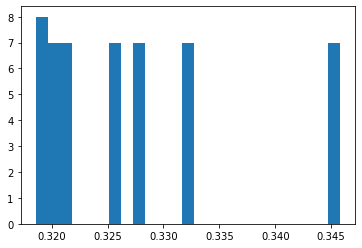

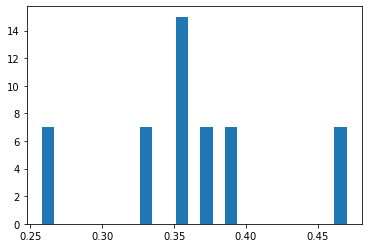

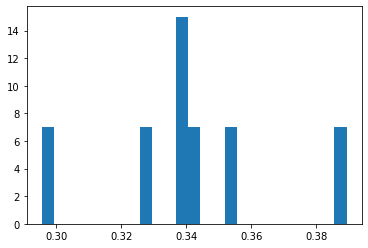

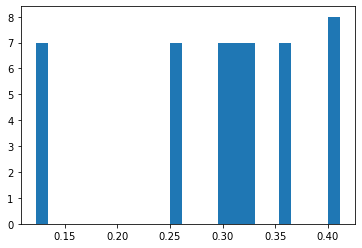

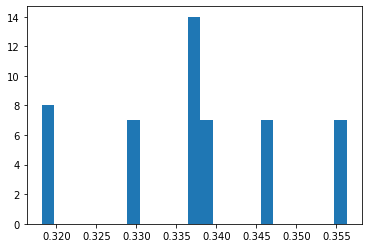

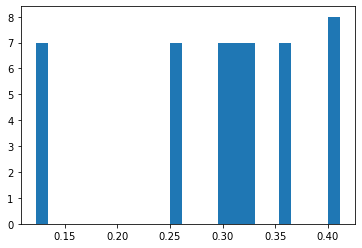

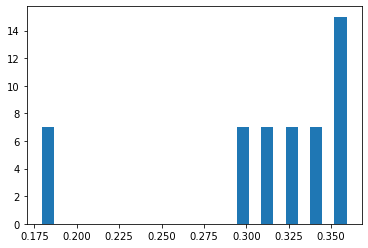

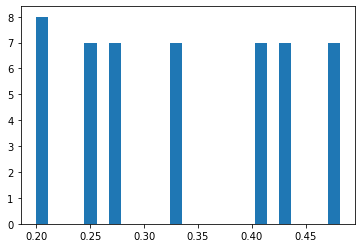

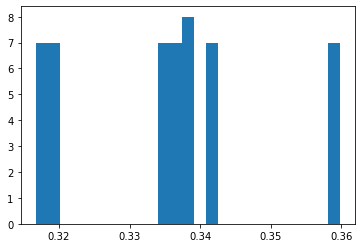

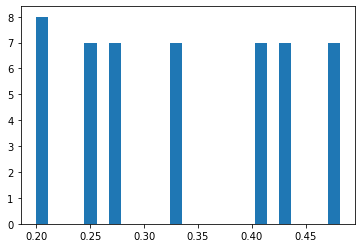

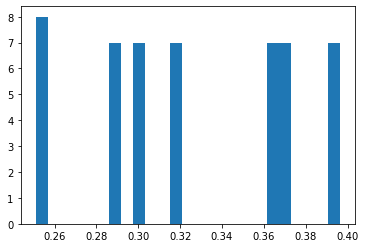

In [46]:
for key in region_yscramb_results_dict.keys():
    value = region_yscramb_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        fig = plt.figure()
        plt.hist(value, bins=25)

In [134]:
region_results_dict = results_dict

(array([ 7.,  0.,  0.,  7.,  0.,  0.,  7.,  7.,  0.,  0.,  0., 15.,  0.,
         0.,  7.]),
 array([0.87435897, 0.87727481, 0.88019064, 0.88310647, 0.88602231,
        0.88893814, 0.89185397, 0.89476981, 0.89768564, 0.90060147,
        0.90351731, 0.90643314, 0.90934897, 0.91226481, 0.91518064,
        0.91809647]),
 <BarContainer object of 15 artists>)

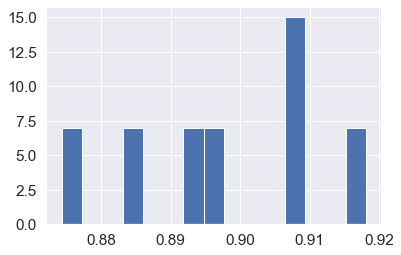

In [161]:
plt.hist(region_results_dict['tot_acc_vals'], bins=15)

In [135]:
region_results_dict

{'tot_acc_vals': array([0.90850837, 0.89553687, 0.88351081, 0.90774015, 0.91809647,
        0.87435897, 0.89308176, 0.90850837, 0.89553687, 0.88351081,
        0.90774015, 0.91809647, 0.87435897, 0.89308176, 0.90850837,
        0.89553687, 0.88351081, 0.90774015, 0.91809647, 0.87435897,
        0.89308176, 0.90850837, 0.89553687, 0.88351081, 0.90774015,
        0.91809647, 0.87435897, 0.89308176, 0.90850837, 0.89553687,
        0.88351081, 0.90774015, 0.91809647, 0.87435897, 0.89308176,
        0.90850837, 0.89553687, 0.88351081, 0.90774015, 0.91809647,
        0.87435897, 0.89308176, 0.90850837, 0.89553687, 0.88351081,
        0.90774015, 0.91809647, 0.87435897, 0.89308176, 0.90850837]),
 'tot_prec_vals': array([0.9096815 , 0.89152517, 0.88339105, 0.90777531, 0.91818072,
        0.87420106, 0.89564096, 0.9096815 , 0.89152517, 0.88339105,
        0.90777531, 0.91818072, 0.87420106, 0.89564096, 0.9096815 ,
        0.89152517, 0.88339105, 0.90777531, 0.91818072, 0.87420106,
        0.895

In [17]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
bal_ecm = bal_ecm.reset_index(drop=True)

Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 44214:27932:10063:2895:10981
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 2895:2895:2895:2895:2895


In [18]:
label_df = bal_ecm[target].copy()
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

In [19]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(label_df)

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [22]:
best_param = {'max_depth': 4,
 'eta': 0.005,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 5,
 'silent': 'True',
 'gamma': 5,
 'subsample': 0.6,
 'colsample_bytree': 0.7,
 'eval_metric': 'mlogloss'}

In [23]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=1157, verbose=False)

Accuracy: 0.5956121343445288


In [24]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

      cortex     0.7740    0.8363    0.8039       733
     ganglia     0.5888    0.3526    0.4411       743
 hippocampus     0.4620    0.5211    0.4898       735
    striatum     0.7744    0.8241    0.7985       762
    thalamus     0.3840    0.4353    0.4081       719

    accuracy                         0.5956      3692
   macro avg     0.5966    0.5939    0.5883      3692
weighted avg     0.5987    0.5956    0.5902      3692



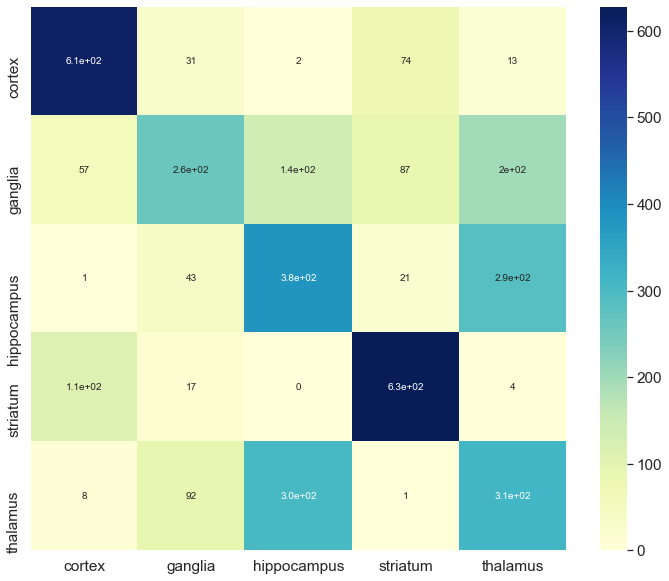

In [30]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
# ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

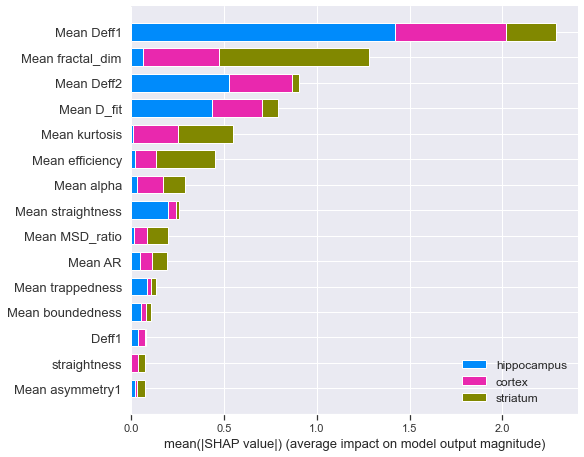

In [16]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')


## Outlier detection

In [189]:
scaler = StandardScaler()
features_df_filled = ecm[features].fillna(0)
scaled_df = scaler.fit_transform(features_df_filled)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [190]:
L, S = r_pca.R_pca(scaled_df).fit(max_iter=5000)

iteration: 1, error: 0.341815954792675
iteration: 100, error: 0.0015104581544473578
iteration: 200, error: 0.0010065056285318832
iteration: 300, error: 0.0009864726351988895
iteration: 400, error: 0.0008990254061599131
iteration: 500, error: 0.0009328012937508472
iteration: 600, error: 0.0008049168018722348
iteration: 700, error: 0.0008994187972853075
iteration: 800, error: 0.0009588175398781066
iteration: 900, error: 0.0007708828404798081
iteration: 1000, error: 0.00078697196848131
iteration: 1100, error: 0.0012087246168022555
iteration: 1200, error: 0.001223631051972385
iteration: 1300, error: 0.0010891395540591942
iteration: 1400, error: 0.0010369995079837892
iteration: 1500, error: 0.0010363311620397088
iteration: 1600, error: 0.0008903524793438219
iteration: 1700, error: 0.000829446884180978
iteration: 1800, error: 0.0008683734727941296
iteration: 1900, error: 0.0007765605167678525
iteration: 2000, error: 0.0008548089342241192
iteration: 2100, error: 0.0008553004139532273
iteratio

In [191]:
S_array = np.absolute(S.values)
S_array

S_magnitudes = np.zeros(len(S))
for i in range(len(S)):
    abs_sum = np.sum(S_array[i])
    S_magnitudes[i] = abs_sum

KeyboardInterrupt: 

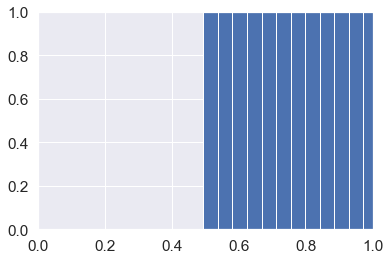

In [67]:
plt.hist(S_magnitudes, bins=5000)

Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

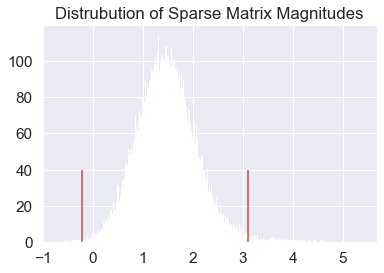

In [26]:
plt.hist(np.log(S_magnitudes), bins=5000)
plt.vlines(np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.vlines(np.log(S_magnitudes).mean()-(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

In [204]:
upper_outlier_cutoff = np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*5)
S_mag_log = np.log(S_magnitudes)
outliers = S_mag_log[S_mag_log > upper_outlier_cutoff]
print(len(outliers))
outlier_inds = np.where(S_mag_log > upper_outlier_cutoff)
normal_inds = np.where(S_mag_log <= upper_outlier_cutoff)
outlier_inds[0]
outlier_df = ecm.iloc[outlier_inds[0]]
normal_df = ecm.iloc[normal_inds[0]]

29


In [205]:
bal_ecm = data_process.balance_data(normal_df, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 44200:27925:10058:2893:10980
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 2893:2893:2893:2893:2893


In [206]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [207]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)

Accuracy: 0.5884819681297176


In [208]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

      cortex     0.7301    0.7738    0.7513       734
     ganglia     0.5741    0.3835    0.4599       717
 hippocampus     0.4286    0.5776    0.4921       670
    striatum     0.8128    0.8019    0.8073       747
    thalamus     0.4059    0.3893    0.3974       709

    accuracy                         0.5885      3577
   macro avg     0.5903    0.5852    0.5816      3577
weighted avg     0.5953    0.5885    0.5859      3577



In [209]:
le_out = preprocessing.LabelEncoder()
outlier_df['encoded_target'] = le_out.fit_transform(outlier_df[target])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [210]:

y_outlier = outlier_df['encoded_target']
d_outliers = xgb.DMatrix(outlier_df[features], label=y_outlier)

In [211]:
true_label = d_outliers.get_label()
ypred = booster.predict(d_outliers)
preds = [np.where(x == np.max(x))[0][0] for x in ypred]
acc = accuracy_score(true_label, preds)
print("Accuracy:",acc)

Accuracy: 0.4827586206896552


In [212]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

      cortex     0.5000    1.0000    0.6667         7
     ganglia     0.5000    0.5000    0.5000         2
 hippocampus     0.0000    0.0000    0.0000         5
    striatum     0.6667    0.4286    0.5217        14
    thalamus     0.0000    0.0000    0.0000         1

    accuracy                         0.4828        29
   macro avg     0.3333    0.3857    0.3377        29
weighted avg     0.4770    0.4828    0.4473        29



# Treatment Data

In [30]:
fstats_tot_treatment = data_process.generate_fullstats(treatment_dataset_path, treatment_filelist, ['NT', 'ChABC'], 'treatment')

Adding file msd_ChABC_brain_3_slice_2_vid_4.csv size: (1240, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_2.csv size: (714, 67)
Adding file msd_NT_brain_4_slice_3_vid_5.csv size: (1876, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_5.csv size: (1212, 67)
Adding file msd_NT_brain_4_slice_3_vid_4.csv size: (2106, 67)
Adding file msd_ChABC_brain_3_slice_2_vid_5.csv size: (2084, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_3.csv size: (1336, 67)
Adding file msd_NT_brain_2_slice_2_vid_1.csv size: (2488, 67)
Adding file msd_NT_brain_3_slice_2_vid_5.csv size: (893, 67)
Adding file msd_NT_brain_2_slice_2_vid_3.csv size: (1735, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_1.csv size: (1788, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_4.csv size: (2689, 67)
Adding file msd_NT_brain_1_slice_3_vid_5.csv size: (1009, 67)
Adding file msd_NT_brain_1_slice_3_vid_4.csv size: (1446, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_5.csv 

In [31]:
target = 'treatment'
ecm = fstats_tot_treatment[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(142453, 36)


(117505, 36)

In [32]:
best_param = {'max_depth': 5, 'eta': 0.05, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 2.0, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss'}
best_boost_rounds = 57

In [33]:
treatment_results_dict = get_multimodel_averages('treatment', ecm['treatment'].unique(), ecm, best_param, 57)

0
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6811972505003046
1
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.7008610697135287
2
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.68879442886859
3
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6885881673405396
4
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6789336910051136
5
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.707799279550976
6
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.7000499085010814
7
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.6811

In [36]:
for key in treatment_results_dict.keys():
    value = treatment_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        print(key)
        print(np.median(value))
        print(stats.iqr(value, interpolation = 'midpoint'))
        print()

tot_acc_vals
0.68879442886859
0.019663819213224132

tot_prec_vals
0.6892886575986341
0.019847646043372413

tot_rec_vals
0.6886060208814487
0.020026284692887697

tot_f1_vals
0.6885880634447941
0.019968932351578816

ChABC_acc_vals
0.668460534898891
0.022841179711373116

ChABC_prec_vals
0.6968054211035818
0.030479839724954272

ChABC_rec_vals
0.668460534898891
0.022841179711373116

ChABC_f1_vals
0.6887679366650173
0.017942988924371073

NT_acc_vals
0.7195056421278883
0.03177200003258274

NT_prec_vals
0.6817718940936863
0.015970320399151583

NT_rec_vals
0.7195056421278883
0.03177200003258274

NT_f1_vals
0.7001307189542484
0.02038523284305238



In [ ]:
treatment_results_dict_binary = get_multimodel_averages('treatment', ecm['treatment'].unique(), ecm, best_param, 57)

In [37]:
treatment_yscramb_results_dict = get_multimodel_averages('treatment', ecm['treatment'].unique(), ecm, best_param, 57, True, True, 50)

0
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.49652260307998014
1
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.5012209460070544
2
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.4868388480897764
3
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.492413446223489
4
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.5025550808410824
5
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.5000831808351356
6
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.49360480292351866
7
Ratio before data balance (ChABC:NT) = 59511:57994
Ratio after balance (ChABC:NT) = 57994:57994
Accuracy: 0.

In [141]:
treatment_results_dict.keys()

dict_keys(['tot_acc_vals', 'tot_prec_vals', 'tot_rec_vals', 'tot_f1_vals', 'booster_list', 'truelabels_list', 'preds_list', 'xtest_list', 'ChABC_acc_vals', 'ChABC_prec_vals', 'ChABC_rec_vals', 'ChABC_f1_vals', 'NT_acc_vals', 'NT_prec_vals', 'NT_rec_vals', 'NT_f1_vals'])

In [38]:
for key in treatment_yscramb_results_dict.keys():
    value = treatment_yscramb_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        print(key)
        print(np.median(value))
        print(stats.iqr(value, interpolation = 'midpoint'))
        print()

tot_acc_vals
0.49652260307998014
0.008807499783565376

tot_prec_vals
0.4965282129029893
0.009100041803052461

tot_rec_vals
0.4965298953193908
0.009091758109748105

tot_f1_vals
0.4964651624898569
0.008856651777566005

ChABC_acc_vals
0.48073056300268097
0.013601401726108797

ChABC_prec_vals
0.49379262108760275
0.014372277553668211

ChABC_rec_vals
0.48073056300268097
0.013601401726108797

ChABC_f1_vals
0.4914354230900993
0.010369927666491918

NT_acc_vals
0.5198751642575559
0.028380120641886553

NT_prec_vals
0.49678293261090417
0.00906958707895178

NT_rec_vals
0.5198751642575559
0.028380120641886553

NT_f1_vals
0.5089484462648027
0.018494943406587527



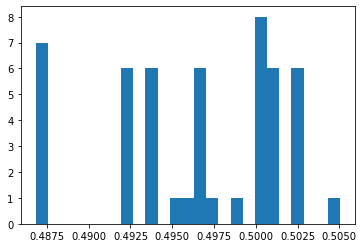

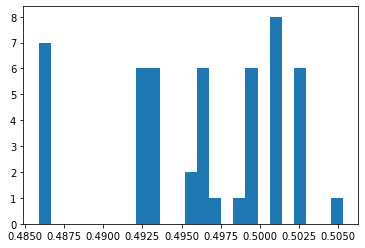

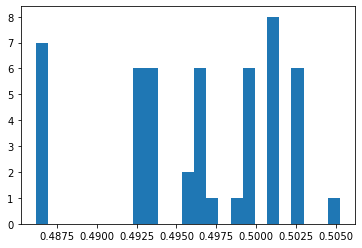

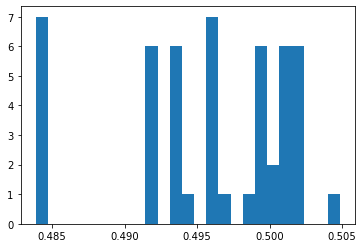

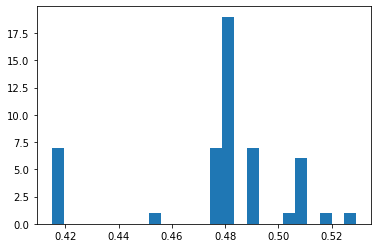

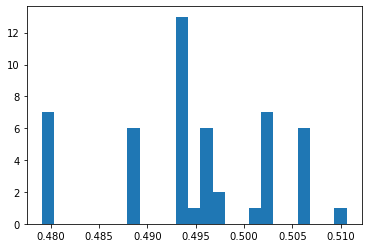

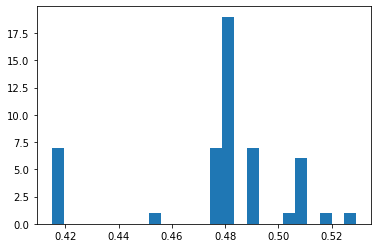

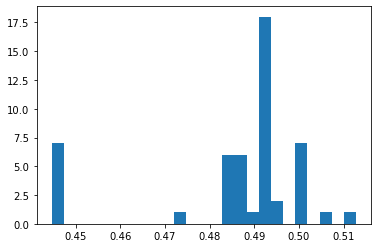

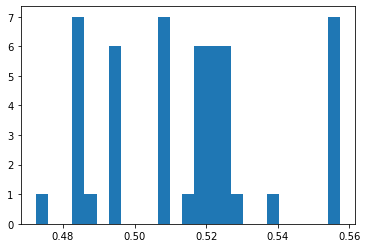

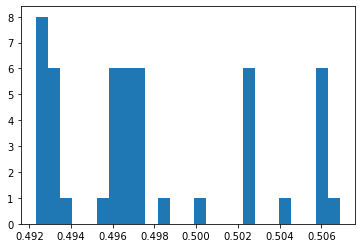

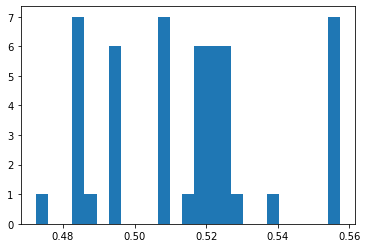

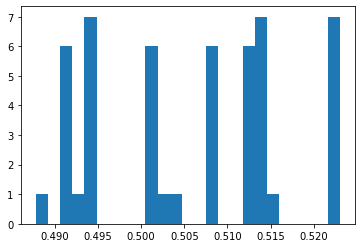

In [44]:
for key in treatment_yscramb_results_dict.keys():
    value = treatment_yscramb_results_dict[key]
    if isinstance(value, (np.ndarray, np.generic) ):
        fig = plt.figure()
        plt.hist(value, bins=25)

In [37]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
label_df = bal_ecm[target]
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

Ratio before data balance (HYase:NT) = 59617:57994
Ratio after balance (HYase:NT) = 57994:57994


In [17]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

104225
5882
5881


In [38]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)

Accuracy: 0.6486346173813726


In [39]:
class_names = le.classes_
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

       HYase     0.6680    0.5922    0.6278     14460
          NT     0.6332    0.7052    0.6672     14433

    accuracy                         0.6486     28893
   macro avg     0.6506    0.6487    0.6475     28893
weighted avg     0.6506    0.6486    0.6475     28893



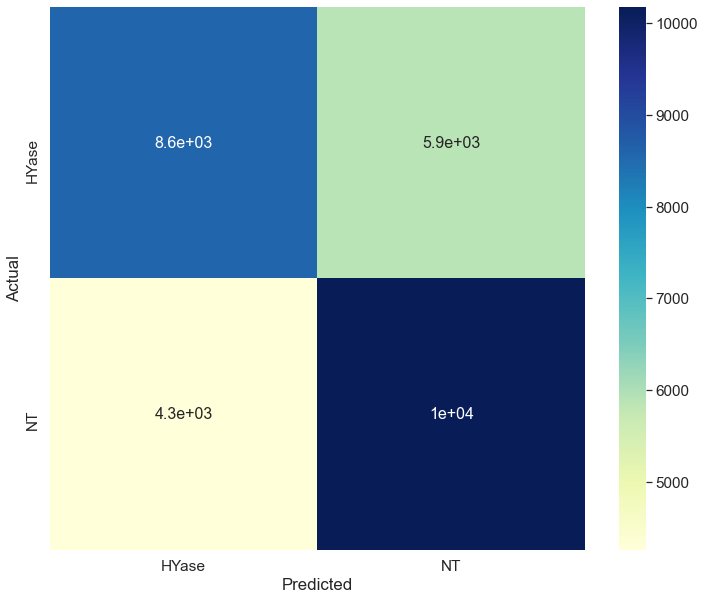

In [40]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

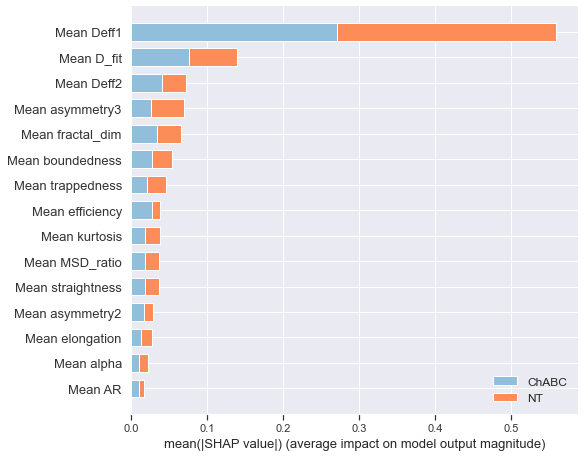

In [34]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#fc8d59'
#c_HYase = '#ffffbf'
c_ChABC = '#91bfdb'

colors = [c_ChABC, c_NT]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)


Text(0.5, 1.0, 'Distrubution of Sparse Matrix Magnitudes')

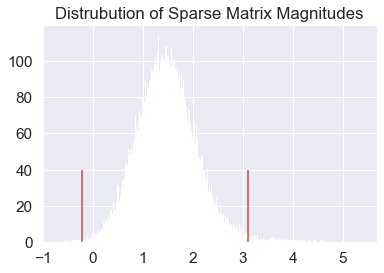

In [74]:
plt.hist(np.log(S_magnitudes), bins=5000)
plt.vlines(np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.vlines(np.log(S_magnitudes).mean()-(np.log(S_magnitudes).std()*3), ymin=0, ymax=40, color='r')
plt.title('Distrubution of Sparse Matrix Magnitudes')

In [128]:
upper_outlier_cutoff = np.log(S_magnitudes).mean()+(np.log(S_magnitudes).std()*5.7)
S_mag_log = np.log(S_magnitudes)
outliers = S_mag_log[S_mag_log > upper_outlier_cutoff]
print(len(outliers))
outlier_inds = np.where(S_mag_log > upper_outlier_cutoff)
normal_inds = np.where(S_mag_log <= upper_outlier_cutoff)
outlier_inds[0]
outlier_df = ecm.iloc[outlier_inds[0]]
normal_df = ecm.iloc[normal_inds[0]]

4


In [129]:
bal_ecm = data_process.balance_data(normal_df, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (ChABC:NT) = 53179:42902
Ratio after balance (ChABC:NT) = 42902:42902


In [130]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [131]:
le = preprocessing.LabelEncoder()
outlier_df['encoded_target'] = le.fit_transform(outlier_df[target])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [132]:

y_outlier = outlier_df['encoded_target']
d_outliers = xgb.DMatrix(outlier_df[features], label=y_outlier)

In [133]:
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds, verbose=False)

Accuracy: 0.6692372801655224


In [134]:
true_label = d_outliers.get_label()
ypred = booster.predict(d_outliers)
preds = [np.where(x == np.max(x))[0][0] for x in ypred]
acc = accuracy_score(true_label, preds)
print("Accuracy:",acc)

Accuracy: 1.0


In [136]:
class_names

array(['ChABC'], dtype=object)

In [135]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

       ChABC     1.0000    1.0000    1.0000         4

    accuracy                         1.0000         4
   macro avg     1.0000    1.0000    1.0000         4
weighted avg     1.0000    1.0000    1.0000         4

